In [2]:
# G part
# Parsing dataset and get X_raw list of strings. I read all pos files first and neg next.
from pathlib import Path
import glob
import numpy as np
file_list_pos = Path('./pos').glob('*.txt')
file_list_neg = Path('./neg').glob('*.txt')
X_raw=[]
y=[]
for file in file_list_pos:
    with file.open() as f_input:
        X_raw.append(f_input.read())
for file in file_list_neg:
    with file.open() as f_input:
        X_raw.append(f_input.read())


#get y label list using while loop
n=2000
while n>0:
    while n>1000:
        y.append(1)
        n=n-1
    y.append(-1)
    n=n-1

In [3]:
#Extracting features

#create a list of mutilple sets
X_set=[]
for i ,doc in enumerate(X_raw):
    X_raw[i]=doc.split()
    X_set.append(set(X_raw[i]))
    
#Get the ordered vocabulary and X vector with shape(numbet of all documents,length of V)
import numpy as np
ordered_vocabulary=sorted(set(sum(X_raw,[])))
X=np.zeros(shape=(len(X_raw),len(ordered_vocabulary)))
for i1,doc in enumerate(X_set):
    for i2,w in enumerate(ordered_vocabulary):
        if w in doc:
            X[i1][i2]=1

In [4]:
#Learning framework

#pseudo input

X=np.insert(X,0,1,axis=1)

#Split traing and testing set in a balanced way

X_training=np.vstack((X[0:800],X[-800:]))
X_testing=X[800:1200]

y_training=y[0:800]+y[-800:]
y_testing=y[800:1200]

#Define the hyperplane model
class Hyperplane_model:
    def __init__(self,lr=0.0001,lambda_p=0.01,iterations=1000):
        self.lr=lr
        self.lambda_p=lambda_p
        self.iterations=iterations
        self.w=np.random.randn(X.shape[1])#define the initial guess for w vector
        
    #use np.sign function to get the predicted label
    def predict(self,X):
        pre_label=np.dot(X,self.w)
        return np.sign(pre_label)
    
    #Calculate the loss score and also include the regularization inside it
    def score(self,X,y):
        loss=0
        for i,x in enumerate(X):
            loss+=max(0,1-y[i]*np.dot(x,self.w))
        regularization=np.sum(self.w**2)
        return loss+(self.lambda_p/2)*regularization   

    def accuracy(self,X,y):
        y=np.array(y)
        return np.sum(y==self.predict(X))/len(y)

    #I inserted gradient descent inside the fit function and use score function inside this function to make the criteria for stop iterating
    def fit(self,X,y):
        update=0
        for _ in range(self.iterations):
            previous_score=self.score(X,y)
            for i,v in enumerate(X):
                condition=y[i]*(np.dot(v,self.w))>=1
                if not condition:
                    update+=-y[i]*v
            omega=self.lambda_p*self.w+update
            self.w -= omega*self.lr
            current_score=self.score(X,y)
            difference=current_score-previous_score
            if abs(difference)<0.1:#define the criteria for stop iterating.I explained why I chose this criteria for in the last analysis
                break

In [4]:
# Exploring hyperparameters
# I use pandas to print the data frame
import pandas as pd
import random
data_dic={"reguliser_dampening":[],"Learning_rate":[],"Train-Accuracy":[]}
para_combi=[]
best_hyperparameters = None
reguliser_dampening= np.exp(np.linspace(np.log(0.0001), np.log(3), 10))
learning_rate=np.exp(np.linspace(np.log(0.0001), np.log(3), 10))
for rd in reguliser_dampening: # Use nested for loop to get all grid points combinations
    for lr in learning_rate:
        para_combi.append((rd,lr))
random.shuffle(para_combi)
slice_tuple=random.sample(para_combi,10)# due to the limitation, I just chose 10 combinations randomly out of 100 grid points
best_hyperparameters = None
for hyperparameters in slice_tuple:
    lam=hyperparameters[0]
    data_dic["reguliser_dampening"].append(lam)
    learningrate=hyperparameters[1]
    data_dic["Learning_rate"].append(learningrate)
    model=Hyperplane_model(lr=learningrate,lambda_p=lam)
    model.fit(X_training,y_training)
    train_accuracy=model.accuracy(X_training,y_training)
    data_dic["Train-Accuracy"].append(train_accuracy)
    if best_hyperparameters is None or best_hyperparameters[1] < train_accuracy:
        best_hyperparameters = (hyperparameters, train_accuracy)
df=pd.DataFrame.from_dict(data_dic)
print(df)
best_learning_rate = best_hyperparameters[0][0]
best_reguliser_dampening = best_hyperparameters[0][1]
print("Best parameters: %.5f, %.5f" % (best_learning_rate, best_reguliser_dampening))
# Its a little weird that all train-accuracies with different patameters are 1.
# Maybe the dataset is so small that the model is overfitting(Professor Fredrick comfirmed it).
# In this case, let's see the result for testing data.

   reguliser_dampening  Learning_rate  Train-Accuracy
0             0.000100       0.030711             1.0
1             0.009769       0.000314             1.0
2             0.003107       0.303533             1.0
3             0.030711       0.954253             1.0
4             0.096549       0.954253             1.0
5             0.000314       0.303533             1.0
6             0.009769       0.096549             1.0
7             0.096549       0.003107             1.0
8             0.000100       0.003107             1.0
9             0.954253       0.000100             1.0
Best parameters: 0.00010, 0.03071


In [22]:
# Get the test dataset accuracy with best parameters
model=Hyperplane_model(lr=0.0001,lambda_p=0.03071)
model.fit(X_training,y_training)
print('%.2f%%' % (model.accuracy(X_testing,y_testing)*100))
#The test accuracy is 84.75% and it's not bad.

84.75%


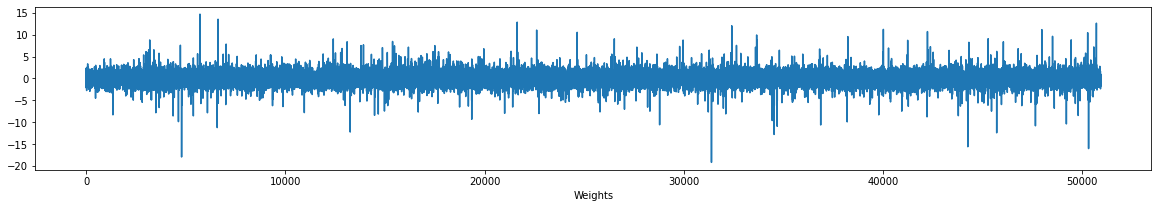

                Word   Weight  Occurences
              reason   -10.633	360 
           sometimes   10.729	203 
       unfortunately   -10.824	329 
                poor   -10.933	174 
                i've   11.069	285 
               until   11.176	377 
                seen   11.232	629 
              boring   -11.235	217 
              others   12.060	246 
            director   -12.248	798 
             through   -12.428	816 
                your   12.648	553 
               point   -12.799	492 
           hilarious   12.880	175 
                both   13.555	620 
                best   14.719	835 
            supposed   -15.610	255 
               worst   -16.031	237 
                 bad   -17.956	760 
             nothing   -19.191	589 


In [23]:
# Define the final decision boundary based on the weight plot
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(model.w[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

assert (len(model.w)-1) == len(ordered_vocabulary)


idx = np.argsort(np.abs(model.w[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick words with highest weights
  print("%20s   %.3f\t%i " % (ordered_vocabulary[i], model.w[i+1], np.sum([ordered_vocabulary[i] in d for d in X_raw])))



The analysis for decision boundary

Generally, the model is over-learning on a large number of the highest weighted words, but it seems to be over-learning specifically on single instances of certain words that do not contribute to making a judgment about whether a review would be positive or negative.For example, the words until, your, others, and reason. On the other hand, the negative words "poor","unfortunately","worst","bad",and "boring" are weighed highly in determining that a review is negative, which totally makes sense, as they have a high number of instances and they would be useful in determining whether a new unseen review is negative or positive.
Also, the same applies for the word like "best" which determines a positive review. I guess that's why my model gets good results in terms of test accuracy. Due to the model over learning on quite a few single instance words that are notary useful for determining polarity, the model still has some loss. Bag of words features don't take the word occurrences into account, so it's more reasonable to consider tf-idf features, where the higher the word frequency is, the higher the weight is.
I chose the parameters that generate the highest training accuracy, since all train accuracies are 100%,just choose the first parameter set.
As for the criteria of stop running iterations,I simply followed the instructions w(t+1)approximately equals w(t);however, it's a little abstract and tricky to compare the similarity between two vectors,so we can employ it in the loss score function to compare if two loss socres are similar.

General analysis

I found the gradient descent part of the assignment to be particularly challenging. It is challenging to implement a method that reflects the mathematical aim of taking the gradient descent, which is to take the derivative of the loss function with respect to each weight iteratively. The analytical equivalent of the derivative that is shown in the assignment is an easier condition to implement in code, but understanding how the function should move through that condition-- namely if y[i] (each element in y)* the weight * X[i]every element in the data vector X >= 0.In my fit function, I employed the whole dataset X_trainig to update the weight in 1 iteration.  

The section in Part 4 that called for tuning the different hyperparameters was also a challenge. It required that we fit the model using the  train data, and using different combinations of hyperparameters, chose the best combination to get maximum accuracy when we tried the model on the test data and not the training data. The model reached 100 percent accuracy right away, and as we can see from the results above, the model never reached anything below 100 percent accuracy on the training set. This seems strange, but it is most likely due to the model overfitting, which is nor surprising given the small data set we are training on. Either way, the fact the model aklways reached 100 percent accuracy made it difficult to tune the hyperparameters to a degree that would be considered optimal. It seems that the only way to tune the hyperparameters would have been to test all the different combinations on the test set, since there was no way to differentiate accuracy on the training set. 

Additonally, it seems the model was overlearning on specific instances of words that had no relevance on whether or not an unseen review would be classified as positive or negative in terms of the polarity of said words. The analysis of the specific instances where this happened can be found above. In general it is not surprising that the model did not reach 100 percent accuracy on the test set given these difficulties. I would also wager that part of the reason the model did not reach a higher accuracy was due to the fact the preprocessing stage only involved splitting in this model, and I did not include any other filters for stopwords or puntuation. 

The loss on the training set ranged from about 40 to 100, which is a pretty good range comparatively, as on the first iteration it started at around 15,000, and as the model went through the 1000 iterations, it reduced significantly. It makes sense then that the model would reach a pretty good accuracy, varying around 85% each time I ran the entire pipeline, but not anything above 90%. 

In terms of the implementation for part three specifically, I found it was more economical to write the code in a way that would mirror the scikitlearn documentation about an SVG classifier, which was also outlined in the general assignment guidelines. Using fit, accuracy and predict made the code more easily comparable to the scikit learn code, which also fascilitated my work in part four， insofar as I was just able to train the model using the training data using the fit method, predict the labels once the model had been trained, and scored the model in terms of how accurate the predictions were compared to the given labels. My score method was implemented especially to return the loss score. 



In [8]:
# VG part
# Implement the optimization as SGD. 
#The central idea of SGD is to update weight using a random datapoint instead of the whole dataset in each iteration 
import random

class SDG_model:
    def __init__(self,lr=0.001,lambda_p=0.001,iterations=1000):
        self.lr=lr
        self.lambda_p=lambda_p
        self.iterations=iterations
        self.w=np.random.randn(X.shape[1])#define the initial guess for w vector
        
    def predict(self,X):
        pre_label=np.dot(X,self.w)
        return np.sign(pre_label)
    
    #Calculate the loss score
    def score(self,X,y):
        loss=0
        for i,x in enumerate(X):
            loss+=max(0,1-y[i]*np.dot(x,self.w))
        regularization=np.sum(self.w**2)
        return loss+(self.lambda_p/2)*regularization   

    def accuracy(self,X,y):
        y=np.array(y)
        return np.sum(y==self.predict(X))/len(y)


    def fit(self,X,y):
        update=0
        for _ in range(self.iterations):
            a=random.randint(0,X.shape[0]-1)
            previous_score=self.score(X,y)
            condition=y[a]*(np.dot(X[a],self.w))>=1
            if not condition:
                update+=-y[a]*X[a]
            omega=self.lambda_p*self.w+update
            self.w -= omega*self.lr
            current_score=self.score(X,y)
            difference=current_score-previous_score
            if abs(difference)<0.01:#define the criteria for stop iterating
                print(current_score)
                break

model=SDG_model()
model.fit(X_training,y_training)
print(model.accuracy(X_testing,y_testing))
#it seems to save a lot of time, 

0.7425


In [9]:
#Implement a tf-idf feature model/due to the limitation of time, I cannot complete the vg part sorry about that.
import math

d={}
X_tfidf=np.zeros(shape=(len(X_raw),len(ordered_vocabulary)))
for w in ordered_vocabulary:
    DF=0
    for doc in X_set:
        if w in doc:
            DF+=1
    d[w]=math.log(len(X_raw)/DF+1)

for i1,doc in enumerate(X_raw):
    for i2,w in enumerate(ordered_vocabulary):
        X_tfidf[i1][i2]=doc.count(w)*d[w]

In [9]:
#Use sklearn to implement 10-fold cross-validation
!wget -N http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
docs = !tar vzxf review_polarity.tar.gz
X_raw=[]

--2021-05-10 21:51:22--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File 'review_polarity.tar.gz' not modified on server. Omitting download.



In [35]:
for doc in docs[:2000]:
    with open(doc[2:],"r") as f:
        X_raw.append(f.read()) 

In [36]:
import numpy as np
array_pos=np.empty(1000,dtype=np.int)
array_pos.fill(1)
array_neg=np.empty(1000,dtype=np.int)
array_neg.fill(-1)
y_raw=np.concatenate((array_pos,array_neg))

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec=TfidfVectorizer()
X=vec.fit_transform(X_raw)
X=X.todense()

In [38]:
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.linear_model import SGDClassifier
kf=KFold(n_splits=10,shuffle=True,random_state=42)
#X_train,X_test,y_train,y_text=train_test_split(X,y.test_size=0.2)
model=SGDClassifier()
scores=cross_val_score(model,X,y_raw,cv=kf)
# best_score=0
# for train_index,test_index in kf.split(X):
#     X_train,X_test=X_train[train_index],X_test[test_index]
#     y_train,y_test=y_train[train_index],y_text[test_index]
#     model.fit(X_train,y_train)
#     current_score=model.score(X_test,y_test)
#     if current_score>best_score:
#         best_score=current_score
#         X_best=X_train
#         y_best=y_train

In [41]:
mean_score=np.mean(np.array(scores))

In [42]:
print(mean_score)

0.8539999999999999
